# Diabetes ML Model

In our exploratory analysis and ML models, we segmented the data by year.  Our results indicated that feature importances were
similar across both years.  In our final model, we will drop year from our data set and analyze all data.

We also learned that BMI is an important factor, and since it is calculated from height and weight, we will remove those features from
the data set.

Finally, we saw that state was consistently an important feature, but since we believe that is not likely to be a causal relationship,
we removed it and found that the models still worked quite well.  

We will apply those lessons here and attemnpt to continue to refine.

In [1]:
# Dependencies
import numpy as np
import pandas as pd 
#import statsmodels.api as sm
#import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score, roc_curve, classification_report
from sklearn.linear_model import LogisticRegression
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
#from sklearn.model_selection import KFold
from collections import Counter
import warnings
warnings.simplefilter(action = "ignore") 

In [2]:
# File to Load (Remember to change the path if needed.)
diabetes = "diabetesDB.csv"

# Read the data and store in Dataframe
df = pd.read_csv(diabetes)
df.shape

(945188, 52)

# Data Prep

In [3]:
# Review nulls
df.isnull().sum()

id               0
_state           0
iyear            0
genhlth          4
physhlth         1
menthlth         0
poorhlth    455451
hlthpln1         0
persdoc2         0
medcost          1
checkup1         1
bphigh4          6
toldhi2     129077
cvdinfr4         1
cvdcrhd4         1
cvdstrk3         0
asthma3          0
asthnow     820948
chccopd1         2
havarth3         2
addepev2        10
chckidny         3
diabete3         0
sex              0
marital        218
educa          349
renthom1      2240
employ1        443
smoke100     14195
smokday2    529325
usenow3      14832
avedrnk2    493051
exerany2     55993
scntmny1    837087
scntmel1    831481
adpleasr    910267
addown      910293
adsleep     910306
adenergy    910314
adeat1      910328
adfail      910341
adthink     910358
admove      910376
mistmnt     910394
adanxev     910406
_race          126
_age_g           0
htm4         22231
wtkg3        52068
_bmi5        63609
_frutsum     62243
_vegesum     70777
dtype: int64

In [4]:
# Remove NaN Values from all other fields (Features); replace with a value that is unused in the raw data set
df.fillna(100, inplace=True)

In [5]:
df.isnull().sum()

id          0
_state      0
iyear       0
genhlth     0
physhlth    0
menthlth    0
poorhlth    0
hlthpln1    0
persdoc2    0
medcost     0
checkup1    0
bphigh4     0
toldhi2     0
cvdinfr4    0
cvdcrhd4    0
cvdstrk3    0
asthma3     0
asthnow     0
chccopd1    0
havarth3    0
addepev2    0
chckidny    0
diabete3    0
sex         0
marital     0
educa       0
renthom1    0
employ1     0
smoke100    0
smokday2    0
usenow3     0
avedrnk2    0
exerany2    0
scntmny1    0
scntmel1    0
adpleasr    0
addown      0
adsleep     0
adenergy    0
adeat1      0
adfail      0
adthink     0
admove      0
mistmnt     0
adanxev     0
_race       0
_age_g      0
htm4        0
wtkg3       0
_bmi5       0
_frutsum    0
_vegesum    0
dtype: int64

# Prepare data for Machine Learning

In [7]:
# split the data into X (features) and y (target):

y = df['diabete3']
X = df.drop(columns=['diabete3','id','_state','iyear','htm4','wtkg3'])
X.describe()

,genhlth,physhlth,menthlth,poorhlth,hlthpln1,persdoc2,medcost,checkup1,bphigh4,toldhi2,...,adfail,adthink,admove,mistmnt,adanxev,_race,_age_g,_bmi5,_frutsum,_vegesum
count,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,...,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,945188.000000,9.451880e+05,9.451880e+05
mean,2.592309,60.631176,64.399970,77.237957,1.119785,1.391746,1.900935,1.601569,2.215451,15.056277,...,99.036208,99.093822,99.253851,96.388232,96.389104,1.990272,4.422571,2603.159951,1.382295e+02,1.845304e+02
std,1.154237,37.041350,35.926294,35.066144,0.504575,0.817551,0.438216,1.270311,1.060227,33.788468,...,7.721615,7.306799,6.044232,18.475206,18.474111,2.495198,1.526921,908.311942,1.311997e+02,1.438683e+02
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,100.000000,5.397605e-79,5.397605e-79
25%,2.000000,15.000000,25.000000,88.000000,1.000000,1.000000,2.000000,1.000000,1.000000,1.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000,3.000000,2289.000000,6.000000e+01,1.000000e+02
50%,3.000000,88.000000,88.000000,88.000000,1.000000,1.000000,2.000000,1.000000,3.000000,2.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000,5.000000,2645.000000,1.000000e+02,1.570000e+02
75%,3.000000,88.000000,88.000000,100.000000,1.000000,1.000000,2.000000,2.000000,3.000000,2.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,1.000000,6.000000,3034.000000,2.000000e+02,2.330000e+02
max,100.000000,100.000000,99.000000,100.000000,9.000000,9.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,6.000000,9995.000000,1.500000e+04,2.046000e+04


In [8]:
# check balance of target column
y.value_counts()

0    809602
1    119717
4     15869
Name: diabete3, dtype: int64

In [9]:
# Transform y values to 0 = no diabetes; 1 = yes, diabetes.  Per BRFSS codebook 4 = prediabetes and we consider this as 'yes, diabetes'

y = y.replace({4:1})
y.value_counts()

0    809602
1    135586
Name: diabete3, dtype: int64

In [28]:
# Split into training and testing data sets
# Remove test size paramenter
X_train, X_test, y_train, y_test = train_test_split(X,y)

Counter(y_train)

Counter({0: 607186, 1: 101705})

In [29]:
# Scale the data

scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [30]:
# Create and fit RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=128)
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=128)

In [31]:
# Make predictions
predictions = rfc.predict(X_test_scaled)

# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)
print(acc_score)

0.8649157627900481


In [32]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[198480   3936]
 [ 27984   5897]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.93    202416
           1       0.60      0.17      0.27     33881

    accuracy                           0.86    236297
   macro avg       0.74      0.58      0.60    236297
weighted avg       0.84      0.86      0.83    236297



In [33]:
# Calculate Feature importances
rfc.feature_importances_

array([0.05327631, 0.03696604, 0.02994474, 0.03298083, 0.00646291,
       0.01544856, 0.00919794, 0.01604085, 0.04187935, 0.02923621,
       0.0113635 , 0.01215736, 0.00821025, 0.008397  , 0.01038264,
       0.01003041, 0.01825561, 0.01292133, 0.00929905, 0.01434072,
       0.0325775 , 0.03644093, 0.01780415, 0.0370034 , 0.01409157,
       0.02097313, 0.00624015, 0.02632955, 0.01922885, 0.01202972,
       0.01144123, 0.00200713, 0.00180799, 0.00236236, 0.00260388,
       0.00223194, 0.00155554, 0.00151449, 0.00152818, 0.00135286,
       0.00134904, 0.02257089, 0.03361409, 0.13184461, 0.07739692,
       0.09530828])

(<AxesSubplot:>,)

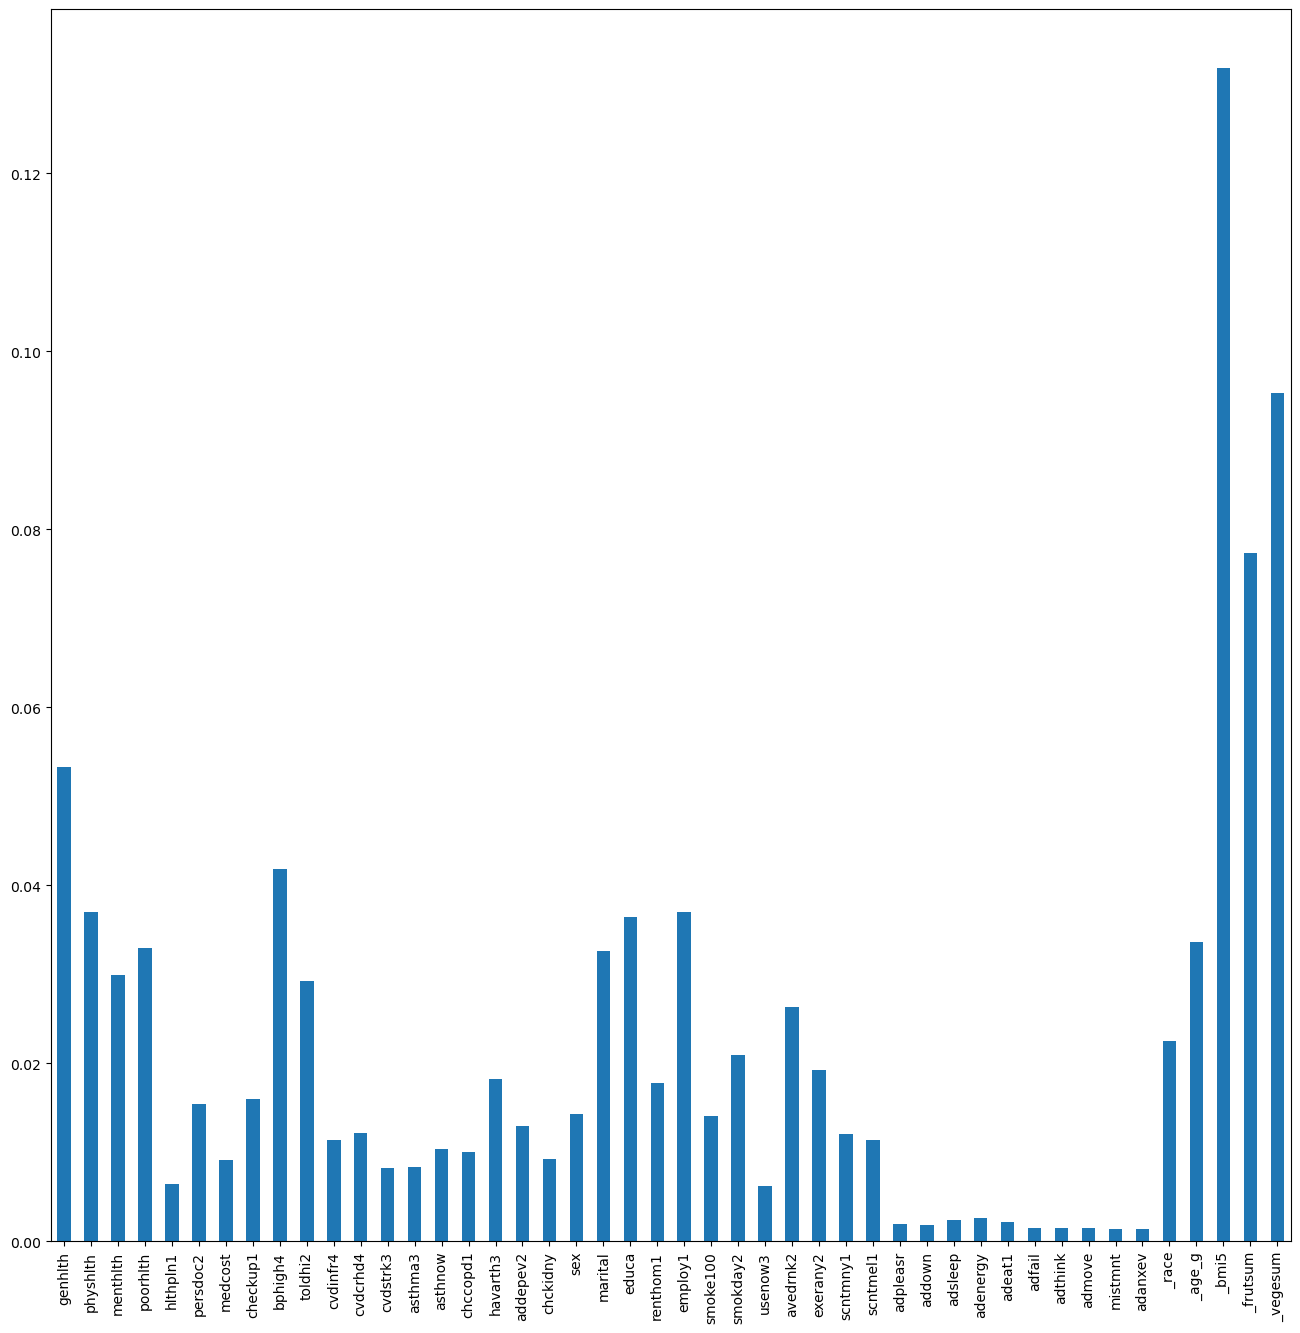

In [34]:
# Plot importances
(pd.Series(rfc.feature_importances_, index=X.columns,).plot(kind='bar', figsize=(16,16)), )

In [35]:
# Based on above importances, reduce the Features to the top 20 most imporantant

index_values = X.columns.to_list()
column_values = ["importance"]
importances = pd.DataFrame(data = rfc.feature_importances_, 
                  index = index_values, 
                  columns = column_values)

importances.sort_values('importance', ascending = False, inplace= True)
importances.head()

,importance
_bmi5,0.131845
_vegesum,0.095308
_frutsum,0.077397
genhlth,0.053276
bphigh4,0.041879


In [36]:
top_20 = importances[0:20]
top_20

,importance
_bmi5,0.131845
_vegesum,0.095308
_frutsum,0.077397
genhlth,0.053276
bphigh4,0.041879
employ1,0.037003
physhlth,0.036966
educa,0.036441
_age_g,0.033614
poorhlth,0.032981


In [37]:
cut = importances[20:]
cut

,importance
persdoc2,0.015449
sex,0.014341
smoke100,0.014092
addepev2,0.012921
cvdcrhd4,0.012157
scntmny1,0.012030
scntmel1,0.011441
cvdinfr4,0.011363
asthnow,0.010383
chccopd1,0.010030


In [38]:
to_cut = cut.index.to_list()
to_cut

['persdoc2',
 'sex',
 'smoke100',
 'addepev2',
 'cvdcrhd4',
 'scntmny1',
 'scntmel1',
 'cvdinfr4',
 'asthnow',
 'chccopd1',
 'chckidny',
 'medcost',
 'asthma3',
 'cvdstrk3',
 'hlthpln1',
 'usenow3',
 'adenergy',
 'adsleep',
 'adeat1',
 'adpleasr',
 'addown',
 'adfail',
 'admove',
 'adthink',
 'mistmnt',
 'adanxev']

In [39]:
# Create new X data with only important columns

X = X.drop(columns=to_cut)
X.head()

,genhlth,physhlth,menthlth,poorhlth,checkup1,bphigh4,toldhi2,havarth3,marital,educa,renthom1,employ1,smokday2,avedrnk2,exerany2,_race,_age_g,_bmi5,_frutsum,_vegesum
0,5.0,15.0,18,10.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,8.0,3.0,100.0,2.0,1.0,5,4018.0,50.0,217.0
1,3.0,88.0,88,100.0,4.0,3.0,2.0,2.0,2.0,6.0,1.0,3.0,1.0,100.0,1.0,1.0,4,2509.0,24.0,78.0
2,4.0,15.0,88,88.0,1.0,3.0,1.0,1.0,2.0,4.0,1.0,7.0,100.0,100.0,100.0,1.0,6,2204.0,100.0,100.0
3,5.0,30.0,30,30.0,1.0,1.0,1.0,1.0,1.0,4.0,1.0,8.0,100.0,100.0,2.0,1.0,5,2819.0,100.0,20.0
4,5.0,20.0,88,30.0,1.0,3.0,2.0,1.0,1.0,5.0,1.0,8.0,100.0,100.0,2.0,1.0,5,2437.0,100.0,200.0


In [41]:
# Re-run model

# Split into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X,y)

Counter(y_train)

Counter({0: 607269, 1: 101622})

In [42]:
# Scale the data

scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [43]:
# Create and fit RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=128)
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=128)

In [44]:
# Make predictions
predictions = rfc.predict(X_test_scaled)

# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)
print(acc_score)

0.8626897506104606


In [45]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[197444   4889]
 [ 27557   6407]]
              precision    recall  f1-score   support

           0       0.88      0.98      0.92    202333
           1       0.57      0.19      0.28     33964

    accuracy                           0.86    236297
   macro avg       0.72      0.58      0.60    236297
weighted avg       0.83      0.86      0.83    236297



In [46]:
# Simplified set of 20 features performs as well in the random forest classifier as the original 53 columns.

In [47]:
# For segment 3:
# Review other machine learning models; can we further downselect features?
# Right now, even if we re-run and re-run the jupyter notebook, the top 20 features remain constant even if we look at 2011 data instead of 2015
# At what number of features does that not remain true?

In [48]:
# Calculate Feature importances
rfc.feature_importances_

array([0.05926348, 0.04609367, 0.03844258, 0.04065432, 0.01838772,
       0.04626706, 0.0329907 , 0.02067916, 0.04042973, 0.04542925,
       0.02153165, 0.04094692, 0.03209573, 0.02954962, 0.02457318,
       0.02629511, 0.03691264, 0.16737203, 0.10201734, 0.13006812])

(<AxesSubplot:>,)

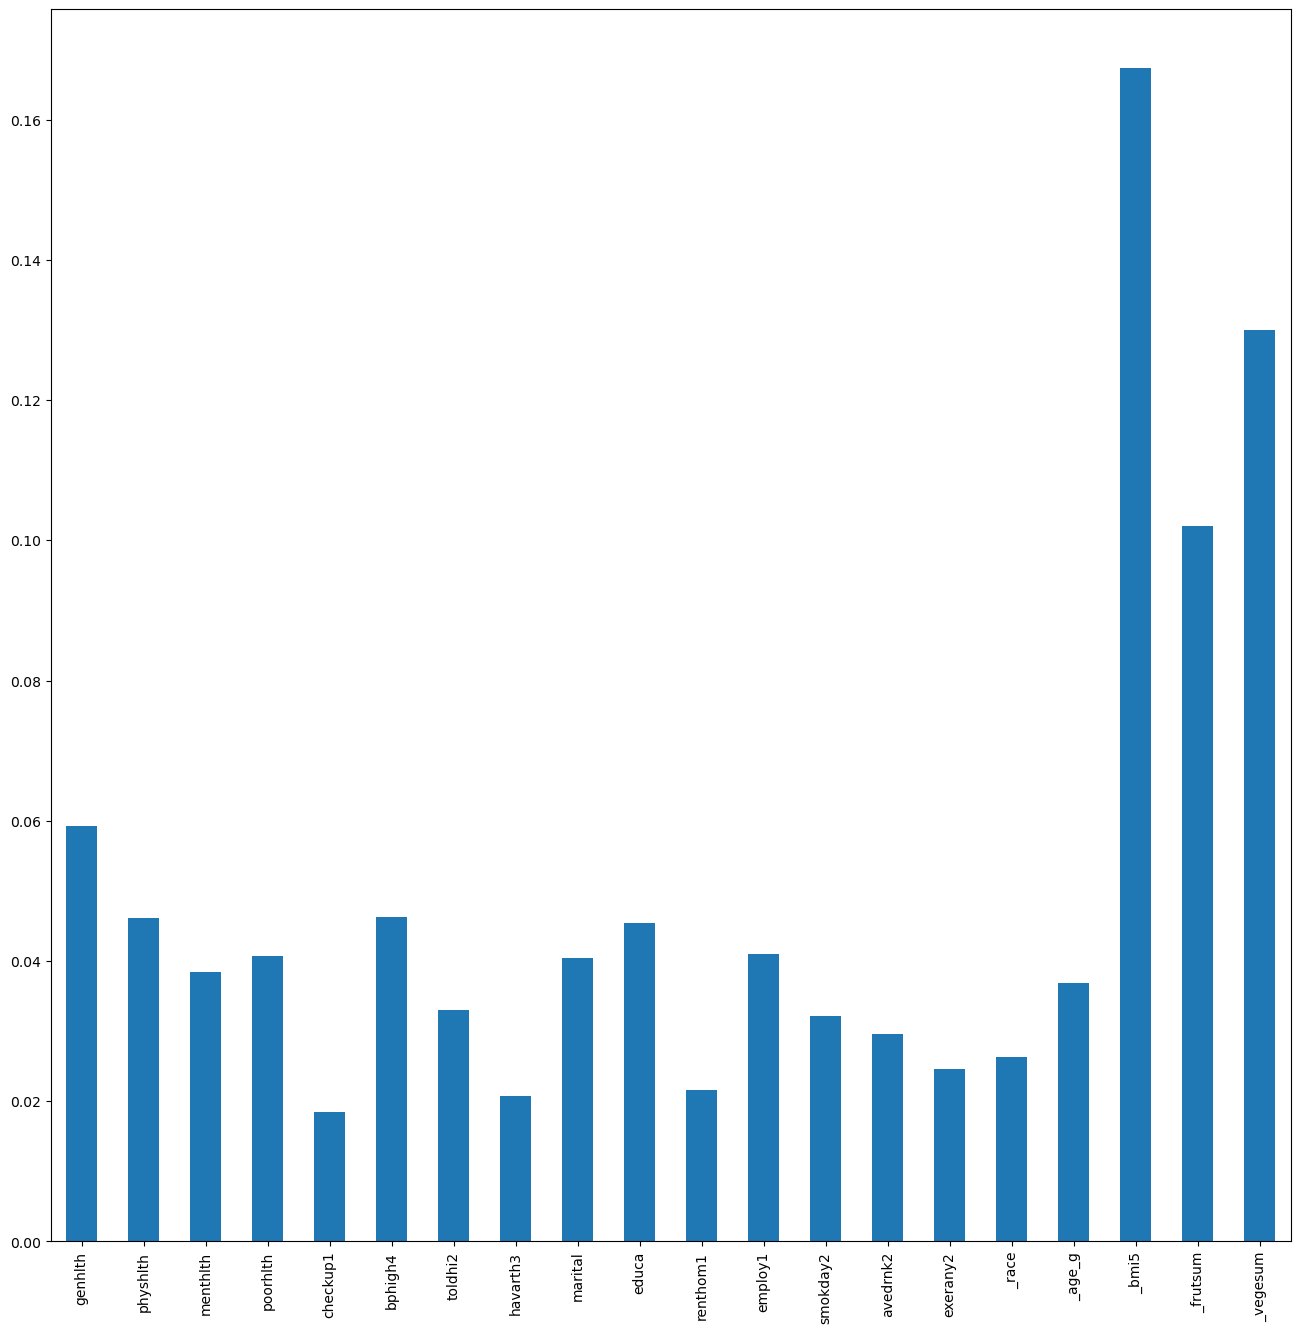

In [49]:
# Plot importances
(pd.Series(rfc.feature_importances_, index=X.columns,).plot(kind='bar', figsize=(16,16)), )

In [50]:
index_values = X.columns.to_list()
column_values = ["importance"]
importances = pd.DataFrame(data = rfc.feature_importances_, 
                  index = index_values, 
                  columns = column_values)

importances.sort_values('importance', ascending = False, inplace= True)
importances.head()

,importance
_bmi5,0.167372
_vegesum,0.130068
_frutsum,0.102017
genhlth,0.059263
bphigh4,0.046267


In [51]:
top_10 = importances[0:10]
top_10

,importance
_bmi5,0.167372
_vegesum,0.130068
_frutsum,0.102017
genhlth,0.059263
bphigh4,0.046267
physhlth,0.046094
educa,0.045429
employ1,0.040947
poorhlth,0.040654
marital,0.040430


In [52]:
cut = importances[10:]
cut

,importance
menthlth,0.038443
_age_g,0.036913
toldhi2,0.032991
smokday2,0.032096
avedrnk2,0.029550
_race,0.026295
exerany2,0.024573
renthom1,0.021532
havarth3,0.020679
checkup1,0.018388


In [53]:
to_cut = cut.index.to_list()
to_cut

['menthlth',
 '_age_g',
 'toldhi2',
 'smokday2',
 'avedrnk2',
 '_race',
 'exerany2',
 'renthom1',
 'havarth3',
 'checkup1']

In [54]:
# Create new X data with only important columns

X = X.drop(columns=to_cut)
X.head()

,genhlth,physhlth,poorhlth,bphigh4,marital,educa,employ1,_bmi5,_frutsum,_vegesum
0,5.0,15.0,10.0,1.0,1.0,4.0,8.0,4018.0,50.0,217.0
1,3.0,88.0,100.0,3.0,2.0,6.0,3.0,2509.0,24.0,78.0
2,4.0,15.0,88.0,3.0,2.0,4.0,7.0,2204.0,100.0,100.0
3,5.0,30.0,30.0,1.0,1.0,4.0,8.0,2819.0,100.0,20.0
4,5.0,20.0,30.0,3.0,1.0,5.0,8.0,2437.0,100.0,200.0


In [56]:
# Re-run model

# Split into training and testing data sets
X_train, X_test, y_train, y_test = train_test_split(X,y)

Counter(y_train)

Counter({0: 607208, 1: 101683})

In [57]:
# Scale the data

scaler = StandardScaler()
# Fitting the Standard Scaler with the training data.
X_scaler = scaler.fit(X_train)

# Scaling the data.
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [58]:
# Create and fit RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=128)
rfc.fit(X_train_scaled, y_train)

RandomForestClassifier(n_estimators=128)

In [59]:
# Make predictions
predictions = rfc.predict(X_test_scaled)

# Calculating the accuracy score.
acc_score = accuracy_score(y_test, predictions)
print(acc_score)

0.8549791152659577


In [60]:
print(confusion_matrix(y_test, predictions))
print(classification_report(y_test,predictions))

[[196179   6215]
 [ 28053   5850]]
              precision    recall  f1-score   support

           0       0.87      0.97      0.92    202394
           1       0.48      0.17      0.25     33903

    accuracy                           0.85    236297
   macro avg       0.68      0.57      0.59    236297
weighted avg       0.82      0.85      0.82    236297



In [61]:
rfc.feature_importances_

array([0.05966643, 0.05995051, 0.05386746, 0.05923227, 0.04800472,
       0.05179037, 0.05081583, 0.24906811, 0.14938678, 0.21821752])

(<AxesSubplot:>,)

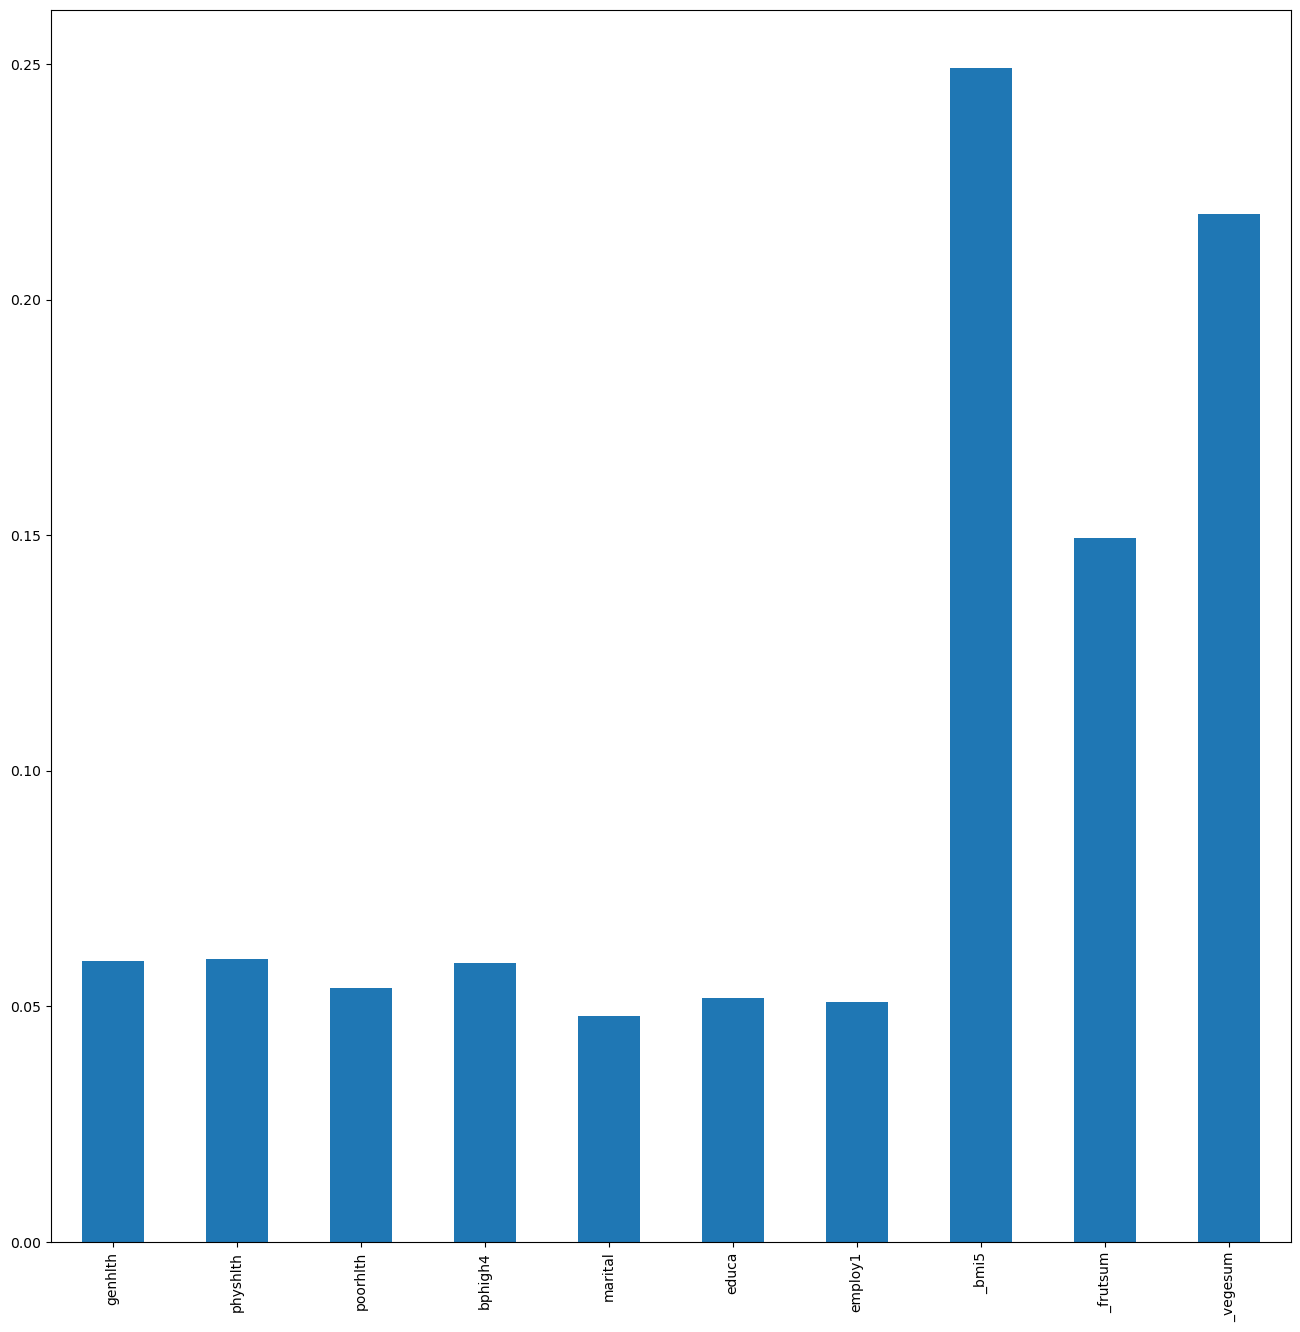

In [62]:
# Plot importances
(pd.Series(rfc.feature_importances_, index=X.columns,).plot(kind='bar', figsize=(16,16)), )